<a href="https://colab.research.google.com/github/amarathe/ELEN521_labs/blob/master/project_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Retinal OCT Images recognition
# Sharanjeet Singh, Ashwin Marathe
Classify images of retina
4 categories: 
    CNV - Choroidal neovascularization
    DME -  Diabetic macular edema 
    DRUSEN - Multiple drusen
    NORMAL - Normal retina

84,000 images in dataset
    
https://www.kaggle.com/paultimothymooney/kermany2018/data#CNV-1016042-2.jpeg

In [1]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image
import pandas as pd
import os.path
from os import path
import glob, os
import random

BATCHSIZE = 64
NSAMPLES = 75000

#Instructions for getting dataset from kaggle:
# https://medium.com/@saedhussain/google-colaboratory-and-kaggle-datasets-b57a83eb6ef8
from google.colab import files
!pip install -q kaggle
#Upload your kaggle.json API file

if not path.exists("/root/.kaggle/kaggle.json"): 
  firsttime = True
  uploaded = files.upload()
  !mkdir ~/.kaggle
  !mv kaggle.json ~/.kaggle/kaggle.json
  !ls -halt ~/.kaggle
  !chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d paultimothymooney/kermany2018






Using TensorFlow backend.


Saving kaggle.json to kaggle.json
total 16K
drwxr-xr-x 2 root root 4.0K Mar 18 23:36 .
drwx------ 1 root root 4.0K Mar 18 23:36 ..
-rw-r--r-- 1 root root   64 Mar 18 23:36 kaggle.json
100% 10.8G/10.8G [04:23<00:00, 71.6MB/s]
100% 10.8G/10.8G [04:23<00:00, 44.2MB/s]


In [0]:
%matplotlib inline


import zipfile
if not path.exists("kermany2018"):
  with zipfile.ZipFile("kermany2018.zip","r") as zip_ref:
    zip_ref.extractall("kermany2018")

#!ls kermany2018/OCT2017\ /train/CNV/ | more
#If first time, partition 5% validation data from training data
if firsttime:
  os.system("mv kermany2018/OCT2017\ /val/ kermany2018/OCT2017\ /backup_val/" )
  os.system("mkdir kermany2018/OCT2017\ /val")
  for label in ["CNV", "DME", "DRUSEN", "NORMAL"]:
    files = list(glob.glob("kermany2018/OCT2017 /train/" + label + "/*.jpeg"))
    random.shuffle(files)
    #print ("glob:", glob.glob("kermany2018/OCT2017 /train/" + label + "/*.jpeg"))
    #print ("files:", files)
    train_files, val_files = files[:int(len(files)*0.95)], files[int(len(files)*0.95):]
    os.system("mkdir kermany2018/OCT2017\ /val/"+label+"/")
    for file in val_files:
      #print ("Moving file:", file, "to: kermany2018/OCT2017\ /val/" + label + "/")
      os.system("mv " + file.replace(" ", "\ ") + " kermany2018/OCT2017\ /val/" + label + "/")
  firsttime = False

#!ls "kermany2018/OCT2017 "
train_datagen = ImageDataGenerator(rescale=1./256)
#valid_datagen = ImageDataGenerator(rescale=1./256)
test_datagen = ImageDataGenerator(rescale=1./256)




In [3]:
# load and iterate training dataset
train_generator = train_datagen.flow_from_directory('kermany2018/OCT2017 /train/', class_mode='categorical', 
                                             target_size=(512,512), batch_size=BATCHSIZE)

#Only 32 images in validation dataset - too small. Use test train split from train dataset
# load and iterate validation dataset
#valid_generator = valid_datagen.flow_from_directory('kermany2018/OCT2017 /val/', class_mode='categorical', 
#                                           target_size=(512,512), batch_size=BATCHSIZE)
valid_generator = train_datagen.flow_from_directory('kermany2018/OCT2017 /val/', class_mode='categorical', 
                                             target_size=(512,512), batch_size=BATCHSIZE)
# load and iterate test dataset
test_generator = test_datagen.flow_from_directory('kermany2018/OCT2017 /test/', class_mode='categorical', 
                                           target_size=(512,512), batch_size=BATCHSIZE)

#traindf = pd.read_csv('kermany2018.zip')

Found 79308 images belonging to 4 classes.
Found 4176 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [4]:
!ls kermany2018/OCT2017\ /val/NORMAL/ | wc -l
!ls kermany2018/OCT2017\ /train/NORMAL/ | wc -l


1316
24999


In [0]:
#for label in ["CNV", "DME", "DRUSEN", "NORMAL"]:

#  files = list(glob.glob("kermany2018/OCT2017 /train/" + label + "/*.jpeg"))
#  random.shuffle(files)
#  #print ("glob:", glob.glob("kermany2018/OCT2017 /train/" + label + "/*.jpeg"))
#  #print ("files:", files)
#  train_files, val_files = files[:int(len(files)*0.95)], files[int(len(files)*0.95):]
#  os.system("mkdir kermany2018/OCT2017\ /val/"+label+"/")
#  for file in val_files:
#    print ("Moving file:", file, "to: kermany2018/OCT2017\ /val/" + label + "/")
#    os.system("mv " + file.replace(" ", "\ ") + " kermany2018/OCT2017\ /val/" + label + "/")

In [0]:
#Returns model and model before last activation (for debug)
def get_model():
    x = x_in = Input((512,512,3), name="input")
    x = Conv2D(8, (3,3), padding="same",  name="fe0")(x)
    x = Activation("relu", name="r0")(x)
    x = MaxPooling2D(2,2,name="mp0")(x)
    x = BatchNormalization(name="bn1")(x)
    x = Conv2D(16, (3,3), padding="same", name="fe1")(x)
    x = Activation("relu", name="r1")(x)
 #   x = MaxPooling2D(2,2,name="mp1")(x)
    x = BatchNormalization(name="bn2")(x)
    x = Conv2D(16, (3,3), padding="same", name="fe2")(x)
    x = Activation("relu", name="r2")(x)
    x = MaxPooling2D(2,2,name="mp2")(x)
    x = BatchNormalization(name="bn3")(x)
    x = Conv2D(32, (3,3), padding="same", name="fe3")(x)
    x = Activation("relu", name="r3")(x)
    x = BatchNormalization(name="bn4")(x)
    x = Conv2D(32, (3,3), padding="same", name="fe4")(x)
    x = Activation("relu", name="r4")(x)
    x = MaxPooling2D(2,2,name="mp3")(x)   
    x = Dropout(0.5, name="d0")(x)
    x = Flatten(name="fl")(x)
    #x = Dense(64, name="d0", activation="relu")(x)
    x = Dense(4, name="d1")(x)
    x = x_int = Activation("softmax", name="s1")(x)
    m = Model(inputs=x_in, outputs=x)
    m_int = Model(inputs=x_in, outputs=x_int)
    m.summary()
    return m, m_int


In [7]:
model, model_int = get_model()
adam = Adam(lr=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["acc"])

result = model.evaluate_generator(test_generator)
print ("Test results with random weights - should be 25%: Accuracy", result[1])
print ("\t Loss:", result[0])

NUM_EPOCHS = 20

history = model.fit_generator(
    train_generator,
    steps_per_epoch=NSAMPLES//BATCHSIZE, # number of times it executes until it declares epoch is over.
    epochs=NUM_EPOCHS,
    validation_data=valid_generator,
    validation_steps=NSAMPLES//(4*BATCHSIZE))













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 512, 512, 3)       0         
_________________________________________________________________
fe0 (Conv2D)                 (None, 512, 512, 8)       224       
_________________________________________________________________
r0 (Activation)              (None, 512, 512, 8)       0         
_________________________________________________________________
mp0 (MaxPooling2D)           (None, 256, 256, 8)       0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 256, 256, 8)       32        
_________________________________________________________________
fe1 (Conv2D)                 (None, 256, 256, 16)      1168     

KeyboardInterrupt: ignored

In [8]:
#for data_batch, labels_batch in train_generator:
#  prediction = model.predict(data_batch)
#  print ("Prediction:", prediction)
#  print ("labels:", labels_batch)
#  break

result = model.evaluate_generator(test_generator)
print ("Test results: Accuracy", result[1])
print ("\t Loss:", result[0])


Test results: Accuracy 0.8099173553719008
	 Loss: 0.47965191760339027


In [0]:
import matplotlib.pyplot as plt
def plothistory(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

# Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [10]:
plothistory(history)

NameError: ignored

Use VGG16 and train last layer

In [61]:
pixels = 128

# load and iterate training dataset
train_generator = train_datagen.flow_from_directory('kermany2018/OCT2017 /train/', class_mode='categorical', 
                                             target_size=(pixels,pixels), batch_size=BATCHSIZE)

#Only 32 images in validation dataset - too small. Use test train split from train dataset
# load and iterate validation dataset
#valid_generator = valid_datagen.flow_from_directory('kermany2018/OCT2017 /val/', class_mode='categorical', 
#                                           target_size=(512,512), batch_size=BATCHSIZE)
valid_generator = train_datagen.flow_from_directory('kermany2018/OCT2017 /val/', class_mode='categorical', 
                                             target_size=(pixels,pixels), batch_size=BATCHSIZE)
# load and iterate test dataset
test_generator = test_datagen.flow_from_directory('kermany2018/OCT2017 /test/', class_mode='categorical', 
                                           target_size=(pixels,pixels), batch_size=BATCHSIZE)

Found 79308 images belonging to 4 classes.
Found 4176 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [62]:
from keras.applications import VGG16

vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
vgg16.summary()

for layer in vgg16.layers[:-4]:
  layer.trainable=False

for layer in vgg16.layers:
  print (layer, layer.trainable)

#x_i = Input((150, 150, 3), name="input")
x_i = Input((pixels,pixels,3), name="input")
x = vgg16(x_i)
x = Flatten(name="fl")(x)
x = Dropout(0.5, name="d5")(x)
x = Dense(64, name="d1", activation="relu")(x)
x = Dense(4, name="d2", activation="softmax")(x)

model = Model(inputs=x_i, outputs=x)
model.summary()

#adam = Adam(lr=0.001)
adam = Adam(lr=0.0001)

model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["acc"])

NSAMPLES = 10000
NUM_EPOCHS=5

history = model.fit_generator(
    train_generator,
    steps_per_epoch=NSAMPLES//100, # number of times it executes until it declares epoch is over.
    epochs=NUM_EPOCHS,
    validation_data=valid_generator,
    validation_steps=NSAMPLES//(2*100))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [65]:
result = model.evaluate_generator(test_generator)
print ("Test results: Accuracy", result[1])
print ("\t Loss:", result[0])

Test results: Accuracy 0.9759814049586777
	 Loss: 0.08266070232657362


x shape: (2000, 128, 128, 3)
y shape: (2000, 4)

              precision    recall  f1-score   support

         CNV       0.92      1.00      0.96       504
         DME       1.00      0.93      0.97       491
      DRUSEN       1.00      0.89      0.94       498
      NORMAL       0.93      1.00      0.96       507

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



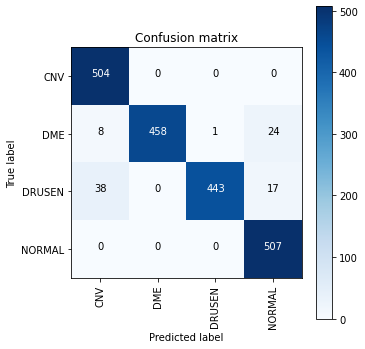

In [67]:
import numpy as np
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#Get Precision, recall, F1 score
num2losses = {0: "CNV", 1: "DME", 2: "DRUSEN", 3: "NORMAL"}

#Get test/train data from generator
xtest, ytest = [],[]
max_iter = 2000
i = 0
for x, y in test_generator:
    for j in range(x.shape[0]):
      xtest.append(x[j])
      ytest.append(y[j])
      i += 1
    if i >= max_iter:
        break

xtest = np.array(xtest)
ytest = np.array(ytest)
print ("x shape:", xtest.shape)
print ("y shape:", ytest.shape)

# From https://www.kaggle.com/chestnut111/new-vgg-model-transfer-for-retina-oct-data-0-96
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(xtest)
print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(num2losses.values())), sep='') 
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(ytest,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plot_confusion_matrix(confusion_mtx, classes = list(num2losses.values()))
plt.show()